In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import timeit
from projectors import *
from scipy.stats import norm, multivariate_normal
import read_matpower_cases
import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pypower.api as P

## First simulation

### Reading the case

In [2]:
fs = read_matpower.first_simulation()
W, tau = fs()

In [3]:
# function for calculating probabilities to get into each half-spaces

def calculate_probas(W,tau):
    return norm.cdf(-tau)

In [4]:
probas = calculate_probas(W, tau)

In [5]:
# elimination of values that are too rare (so that further computations become possible)
critical_value = 1e-300
valid_idx = np.argwhere(probas >= critical_value)[:,0]
probas = probas[valid_idx]
W = W[valid_idx]
tau = tau[valid_idx]

In [6]:
DIM_X = W.shape[1]
NUM_B = W.shape[0]
eps = 0.1 / (NUM_B + 1) # lower bound which prevents alpha values from being equal to zero



#W = np.random.randn(NUM_B, DIM_X)
#W = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, W)
#tau = np.fabs(np.random.randn(NUM_B))

In [7]:
# function which return 1 if x lies in some definite halfspace and 0 otherwise

def boundaries(x, W, tau):
    return (W.dot(x) >= tau).astype(int)

In [8]:
boundaries_wrap = lambda x: boundaries(x, W, tau)

In [11]:
# generating samples conditioning on one of halspaces

def generate_sample(W, tau, mix_index):
    if mix_index == len(W):
        return np.random.randn(DIM_X)
    w = W[mix_index]
    t = tau[mix_index]
    z = np.random.randn(DIM_X)
    u = np.random.rand()
    y = u * norm.cdf(-t)
    y = norm.ppf(y)
    return -y*w - z + (w.dot(z)) * w

In [12]:
generate_wrap = lambda i: generate_sample(W, tau, i)

In [13]:


class Mixture():
    '''Class operating with distribution mixtures, 
    derived from some base distribution function conditioning on different halfspaces'''
    def __init__(self, dist_func, boundaries, probas, gen_funcs, block = True):
        self.base_dist = dist_func # base distribution function
        self.boundaries = boundaries 
        self.probas = probas
        self.gen_funcs = gen_funcs 
        self.valid_idx = np.argwhere(self.probas != 0)[:,0] #in this implementation aren't required
        self.block = block #in this implementation aren't required

    '''def block_invalid_boundaries(boundaries):
        return boundaries[self.valid_idx]'''
            
    def set_alpha(self, alpha):
        '''Function to change alpha which class is operating '''
        self.alpha = alpha
        #if self.block:
        #    self.alpha = self.alpha[self.valid_idx]
        #    norm = self.alpha.sum()
        #    self.alpha = self.alpha / norm
        
    def mix_pdf(self, x):
        '''probability density functions of all distributions which are present in the mixture''' 
        #if self.block:
        #    return self.base_dist(x) * self.boundaries(x)[self.valid_idx] / self.probas[self.valid_idx]
        return self.base_dist(x) * self.boundaries(x) / self.probas
    
    '''def mix_dist(self, x):
        res = 0
        for i, a in enumerate(self.alpha):
            if i != len(self.alpha) - 1:
                res += a*self.base_dist(x)*self.boundaries(i, x)/self.probas[i]
            else:
                res += a*self.base_dist(x)
        return res'''

    def mix_dist(self, x, block = True):
        '''probability density function of the whole mixture'''
        probas = self.probas
        bounds = self.boundaries(x)
        #if self.block:
        #    probas = self.probas[self.valid_idx]
        #    bounds = self.boundaries(x)[self.valid_idx]
        p = self.base_dist(x)
        coef = 1 / probas
        coef = p * coef
        bounds = bounds* coef
        print(bounds)
        res = self.alpha[:-1].dot(bounds)
        res += self.alpha[-1] * p
        return res

    
    def sample(self):
        n = len(self.alpha)
        choice = np.random.choice(n, p=self.alpha)
        #if self.block:
        #    choice = self.valid_idx[choice]
        return self.gen_funcs(choice)
        
        

In [14]:
dist_func = lambda x: multivariate_normal.pdf(x, np.zeros((DIM_X)), np.identity(DIM_X))
mixture = Mixture(dist_func, boundaries_wrap, probas, generate_wrap)

### First optimization task

$$
\text{Var } \hat \mu_{\alpha} = \frac 1n \left(\int \frac{H_{1:J}(x) p(x)}{\sum_{j=0}^J \alpha_j H_j (x) P_j^{-1}} \, dx  - \mu^2\right)\longrightarrow \min_{\alpha}
$$

We are going to use stochastic gradient descent. The stochastic gradient of this task, having $X_i \sim q_{\alpha}(x)$ is $-\dfrac{H_{1:J}(X_i) p^2(X_i) \vec q (X_i)}{q_{\alpha}^3(X_i)}$

Estimation of the variance above:
$$
\frac 1n \sum_{i = 1}^n \frac{H_{1:J}(x_i) p^2(x_i)}{q_{\alpha} (x_i) q_{\alpha'}(x_i)} \longrightarrow \min_{\alpha}
$$
where $x_i \sim q_{\alpha'}$

#### Owen's implementation described in https://arxiv.org/pdf/1411.3954.pdf

In [15]:
simul_num1 = 10**4
simul_num2 = 10**5
dim_alpha = NUM_B + 1
dim_beta = NUM_B
dim_gamma = NUM_B

In [17]:
# main function description which we want to minimize
def calculate_coefs(mixture, simul_num = 10**4):
    bound_num = len(mixture.alpha)
    coefs_x = np.zeros((simul_num, bound_num))
    coefs_y = np.zeros((simul_num))
    coefs_z = np.zeros((simul_num))
    alpha = mixture.alpha
    for i in range(simul_num):
        x = mixture.sample()
        h = 0
        if np.any(mixture.boundaries(x)):
            h = 1
        coefs_y[i] = h
        coefs_x[i, :-1] = mixture.boundaries(x) / mixture.probas
        coefs_x[i, -1] = 1
        coefs_z[i] =  alpha.dot(coefs_x[i,:])
    coefs = (coefs_x, coefs_y, coefs_z)
    return coefs

def func(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5):
    bound_num = len(alpha)
    if np.any(beta) == None:
        beta = np.zeros((bound_num - 1))
    if np.any(gamma) == None:
        gamma = np.zeros((bound_num - 1))
    x, y, z = coefs
    alpha = alpha.reshape((-1, 1))
    to_sum = x.dot(alpha)
    to_sum = to_sum.ravel()
    to_sum = np.divide(np.ones((to_sum.size,)), to_sum)
    normalizer = y - x[:,:-1].dot(beta) + gamma.sum()
    to_sum = to_sum * normalizer
    to_sum = to_sum * (normalizer / z)
    temp = (gamma - beta).sum()
    return to_sum.sum() - 2*(y / z).sum()*temp + (sample_num -1)*(temp**2)*(simul_num) ### to check

def grad_func(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5):
    bound_num = len(alpha)
    checker = np.any(beta) == None
    if checker:
        beta = np.zeros((bound_num - 1))
        gamma = np.zeros((bound_num - 1))
    x,y,z = coefs
    alpha = alpha.reshape((-1, 1))
    norm = y - x[:,:-1].dot(beta) + gamma.sum()
    normalizer = norm / z
    norm = normalizer * norm
    res = x.dot(alpha)
    #res = res **2
    #print(len(res[res == np.inf]))
    coef = - x / res
    x = coef / res

    grad_a = (x.T.dot(norm)).ravel()
    if checker:
        return grad_a
    temp = (gamma - beta).sum()
    mu = (y / z).sum()
    grad_b = ((coef[:,:-1]).T.dot(normalizer)).ravel() + mu - (sample_num - 1) * temp*simul_num
    grad_b = 2 * grad_b
    grad_g = normalizer.dot(1 / res.ravel()) - mu + (sample_num - 1) * temp*simul_num
    grad_g = 2* grad_g
    grad_g = np.ones((bound_num - 1)) * grad_g
    return  np.hstack((grad_a, grad_b, grad_g))

def hess_func(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5):
    bound_num = len(alpha)    
    checker = np.any(beta) == None
    if checker:
        beta = np.zeros((bound_num - 1))
        gamma = np.zeros((bound_num - 1))
    x,y,z = coefs
    y = y.reshape((-1,1))
    z = z.reshape((-1,1))
    norm = y - x[:,:-1].dot(beta.reshape((-1,1))) + gamma.sum()
    normalizer = norm / z
    norm = normalizer * norm
    alpha = alpha.reshape((-1, 1))
    res = x.dot(alpha)
    coefs = x / res
    hess_a = 2 * (coefs * norm).T.dot(coefs / res)
    if checker:
        return hess_a
    hess_ab = 2 * (coefs * normalizer).T.dot(coefs[:, :-1] / res)
    #hess_ag = np.zeros((len(gamma), 1))
    hess_ag = -2 * (coefs * normalizer).T.dot(1 / res)
    hess_ag = np.repeat(hess_ag, len(gamma), axis = 1)
    hess_b = 2 * (coefs[:, :-1]).T.dot(x[:, :-1] / z) + 2 * (sample_num - 1)* simul_num
    hess_bg = -2 * (coefs[:,:-1]).T.dot(1 / z) - 2 * (sample_num - 1) * simul_num
    hess_bg = np.repeat(hess_bg, len(gamma), axis = 1)
    hess_g = 2*((1 / res) / z).sum() + 2 * (sample_num - 1)* simul_num
    hess_g = hess_g * np.ones((len(gamma), len(gamma)))
    hess_a = np.hstack((hess_a, hess_ab, hess_ag))
    hess_b = np.hstack((hess_ab.T, hess_b, hess_bg))
    hess_g = np.hstack((hess_ag.T, hess_bg.T, hess_g))
    return np.vstack((hess_a, hess_b, hess_g))

In [18]:
eta = 1e-2
delta = (1 + eta - (NUM_B + 1)*eps) / (NUM_B + 2)
zero_alpha = (eps + delta) * np.ones((NUM_B + 1)) # zero alpha for optimization
sample_alpha = np.ones((NUM_B + 1)) / (NUM_B + 1) #alpha which will be used for the first simulation stage
sample_alpha[np.argmax(sample_alpha)] += 1 - sample_alpha.sum()
mixture.set_alpha(sample_alpha)
coefs = calculate_coefs(mixture)

In [19]:
# addition of log barriers
def log_barrier(bound_values, rho = 1):
    bound_values = np.log(bound_values)
    return - rho * np.sum(bound_values)

def big_func(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5, rho = 1, eta = 0.01):
    bound_values = alpha - eps
    bound_values = np.hstack((bound_values, np.array(1 + eta - np.sum(alpha))))
    res = func(coefs, alpha, beta, gamma, simul_num, sample_num) + log_barrier(bound_values, rho)
    return res

def big_grad(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5, rho = 1, eta = 0.01):
    bound_values = alpha - eps
    bound_values = 1.0 / bound_values
    upper_bound = 1 + eta - np.sum(alpha)
    upper_bound = 1.0 / upper_bound
    barrier_part = (upper_bound - bound_values) * rho
    gr = grad_func(coefs, alpha, beta, gamma, simul_num, sample_num)
    if np.any(beta) == None:
        return barrier_part + gr
    else:
        return np.hstack((barrier_part, np.zeros((gr.size - barrier_part.size)))) + gr

def big_hess(coefs, alpha, beta = None, gamma = None, simul_num = 10**4, sample_num = 10**5, rho = 1, eta = 0.01):
    bound_values = alpha - eps
    bound_num = len(alpha)
    bound_values = 1.0 / (bound_values)**2
    upper_bound = 1 + eta - np.sum(alpha)
    upper_bound = 1.0 / upper_bound ** 2
    barrier_part = (np.diag(bound_values) + np.ones((alpha.size, alpha.size)) * upper_bound) * rho
    he = hess_func(coefs, alpha, beta, gamma, simul_num, sample_num)
    b_p = np.zeros(he.shape)
    b_p[:bound_num, :bound_num] = barrier_part
    return b_p + he

In [20]:
# search for the appropriate step size for the given direction
def backtracking_line_search(direction, func, grad_func, dom_func, point, update, alpha = 0.3, beta = 0.8):
    t = 1
    x = point
    f_x = func(x)
    gr_x = grad_func(x)
    while not dom_func(update(x,direction, t)):
        #print("2. jkjdf")
        t = beta*t
    while func(update(x, direction, t)) > f_x + alpha*t*(gr_x.dot(direction)):
        #print("3. jdkfjldj")
        t = beta*t
    return t

In [21]:
def update1(x, direction, t):
    return x + t*direction.ravel()
    
### This function tends to stick in a cycle with some eta, to be checked later

def damped_newton(func, grad_func, hess, dom_func, point, update, tolerance = 1e-4):
    x = point
    while True:
        grad = grad_func(x).reshape((-1,1))
        hess_inv = np.linalg.pinv(hess(x))
        direction = - hess_inv.dot(grad)
        decrement = grad.T.dot(hess_inv)
        decrement = decrement.dot(grad)
        #print(decrement)
        if decrement**2 / 2 <= tolerance:
            break
        print(decrement**2/2)
        t = backtracking_line_search(direction.ravel(), func, grad_func, dom_func, x)
        x = update(x, direction, t) 
        #x = tuple(x[i] + t*direction.ravel()[i*len(x[0]): ]) x + t* direction.ravel()
    return x

In [22]:
#eta = 1e-3
tol_e = 1e-4
rho = 1
dom_func = lambda x: np.all(x >= eps) & (x.sum() < 1 + eta)
params_to_opt = zero_alpha
while True:
    print('rho:', rho)
    func_wrap = lambda x: big_func(coefs, x, rho = rho)
    grad_wrap = lambda x: big_grad(coefs, x, rho = rho)
    hess_wrap = lambda x: big_hess(coefs, x, rho = rho)
    params_to_opt = damped_newton(func_wrap, grad_wrap, hess_wrap, dom_func, params_to_opt, update=update1)
    if (NUM_B + 2) * rho < func(coefs, params_to_opt) * tol_e:
        break
    else: rho = rho / 2

rho: 1
rho: 0.5
rho: 0.25
rho: 0.125
rho: 0.0625
rho: 0.03125
rho: 0.015625
rho: 0.0078125
rho: 0.00390625
rho: 0.001953125
rho: 0.0009765625
rho: 0.00048828125
rho: 0.000244140625
rho: 0.0001220703125
rho: 6.103515625e-05
rho: 3.0517578125e-05
rho: 1.52587890625e-05
rho: 7.62939453125e-06
rho: 3.814697265625e-06
rho: 1.9073486328125e-06
rho: 9.5367431640625e-07
rho: 4.76837158203125e-07
rho: 2.384185791015625e-07
rho: 1.1920928955078125e-07
rho: 5.960464477539063e-08
rho: 2.9802322387695312e-08
rho: 1.4901161193847656e-08
rho: 7.450580596923828e-09
rho: 3.725290298461914e-09
rho: 1.862645149230957e-09
rho: 9.313225746154785e-10
rho: 4.656612873077393e-10
rho: 2.3283064365386963e-10
rho: 1.1641532182693481e-10
rho: 5.820766091346741e-11
rho: 2.9103830456733704e-11
rho: 1.4551915228366852e-11
rho: 7.275957614183426e-12
rho: 3.637978807091713e-12
rho: 1.8189894035458565e-12
rho: 9.094947017729282e-13
rho: 4.547473508864641e-13
rho: 2.2737367544323206e-13
rho: 1.1368683772161603e-13
rho: 

In [23]:
def get_estimation(mixture, projector, alpha, beta = None, gamma = None, sample_num = 10**5):
    bound_num = len(mixture.alpha)
    if np.any(beta) == None:
        beta = np.zeros((bound_num - 1))
        gamma = np.zeros((bound_num - 1))
    alpha = projector(alpha)
    alpha[np.argmax(alpha)] += 1 - alpha.sum()
    mixture.set_alpha(alpha)
    x,y,z = calculate_coefs_alt(mixture, sample_num)
    nom = y - x[:, :-1].dot(beta) + gamma.sum()
    denom = x.dot(alpha)
    est = np.mean(nom / denom)
    return est - (gamma - beta).sum()


In [24]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params_to_opt)

1.5234048159518705e-08

In [25]:
fs.right_answer - get_estimation(mixture, proj, params_to_opt)

-9.3191121769103368e-12

#### Stochastic gradient descent

In [26]:
def update2(x, direction):
    sizes = tuple(len(x_i) for x_i in x)
    start_idx = []
    idx = 0
    for i in range(len(x)):
        start_idx.append(idx)
        idx += sizes[i]
    return [x[i] + direction[start_idx[i]: start_idx[i] + sizes[i]] for i in range(len(x))]

#######################################################333
#SHOULD BE FINISHED LATER
#########################################################

def sgd(objective, mixture, grad, zero_point, projector, C = 1, max_iter = 10**5, update = update2, momentum = None):
    points = []
    checker = momentum == None
    cur_point = zero_point[:]
    estim = []
    points.append(cur_point)
    cumsum = 0
    for i in range(max_iter):
        
        #sample part
        try:
            mixture.set_alpha(cur_point[0])
            cur_x = mixture.sample()
        except:
            cur_point[0][np.argmax(cur_point[0])] += 1 - np.sum(cur_point[0])
            mixture.set_alpha(cur_point[0])
            cur_x = mixture.sample()
        x = cur_x
        
        # estimation part
        if len(cur_point) > 1:
            bias = (cur_point[2] - cur_point[1]).sum()
        else:
            bias = 0
        
        tmp = objective(x, cur_point)
        
        cumsum += tmp - bias
        estim.append(cumsum / (i + 1))
        
        #gradient part
        if (checker) | (i == 0):
            gradient = grad(x, cur_point)
        else:
            direction = momentum * direction 
            gradient = grad(x, update(cur_point, direction))
        
        # step part
        step_size = C/np.sqrt(i+1)
        #step_size = C
        if (checker) | (i == 0):
            direction = -gradient * step_size
        else:
            direction -= gradient * step_size
        
        cur_point = update(cur_point, direction) ######################## check!!!bb
        
        #alert if some problems with alpha occurs
        if np.any(np.isinf(cur_point[0])):
            print('Iteration # {}: infinity trouble'.format(i + 1))
            print(cur_point[0])
            print(cur_point[1])
            print(cur_point[2])
        if np.any(np.isnan(cur_point[0])):
            print('Iteration # {}: nan trouble'.format(i + 1))
            
        #projector part
        cur_point[0] = projector(cur_point[0]) ################# necessary to check later
    
        points.append(cur_point)            
        if (i + 1) % 1000 == 0:
            print("Iteration #{}".format(i + 1))
    return np.array(estim), points

In [162]:
def obj1(x, mixture, alpha, beta = None, gamma = None):
    bound_num = len(alpha)
    if np.any(beta) == None:
        beta = np.zeros((bound_num - 1))
        gamma = np.zeros((bound_num - 1))
    h = 0
    bounds = mixture.boundaries(x)
    if np.any(bounds):
        h = 1
    bounds = bounds / mixture.probas
    nom = h - bounds.dot(beta) + gamma.sum()
    denom = bounds.dot(alpha[:-1]) + alpha[-1]
    return nom / denom

def grad1(x, mixture, alpha, beta = None, gamma = None, sample_num = 10**5):
    bound_num = len(alpha)
    checker = np.any(beta) == None
    if checker:
        beta = np.zeros((bound_num - 1))
        gamma = np.zeros((bound_num - 1))
    h = 0
    bounds = mixture.boundaries(x)
    if np.any(bounds):
        h = 1
    bounds = bounds / mixture.probas
    nom = h - bounds.dot(beta) + gamma.sum()
    denom = bounds.dot(alpha[:-1]) + alpha[-1]
    frac = nom / denom
    grad_a = np.ones((bound_num))
    grad_a = grad_a*((frac)**2)
    grad_a[:-1] = grad_a[:-1] * bounds
    grad_a = -grad_a / denom
    if checker:
        return grad_a
    
    if np.any(np.isinf(grad_a)):
        print('infinity trouble with grad_a')
    if np.any(np.isnan(grad_a)):
        print('nan trouble with grad_a')

    mu = h / denom
    grad_b = frac * (bounds / denom)
    grad_b -= mu
    grad_b = grad_b * (-2) +  beta
    if np.any(np.isinf(grad_b)):
        print('infinity trouble with grad_b')
    if np.any(np.isnan(grad_b)):
        print('nan trouble with grad_b')
        
    grad_g = frac * (1 / denom) - mu 
    grad_g = grad_g * 2
    grad_g = np.ones((bound_num - 1)) * grad_g +  gamma
    if np.any(np.isinf(grad_g)):
        print('infinity trouble with grad_g')
    if np.any(np.isnan(grad_g)):
        print('nan trouble with grad_g')
    return np.hstack((grad_a, grad_b, grad_g))
    

In [196]:
obj = lambda x, params: obj1(x, mixture, params[0])
grad = lambda x, params: grad1(x, mixture, params[0])


In [197]:
zero_p = (1 / (NUM_B + 1)) * np.ones((NUM_B + 1))
proj = SimplexProjector(epsilon = eps)

In [212]:
zero_p = [zero_p]
zero_p1 = np.ones((NUM_B + 1))* eps
zero_p1[-1] += 1 - zero_p1.sum()
zero_p = [zero_p1]

In [213]:
est1, alphas = sgd(obj, mixture, grad, zero_p, proj, max_iter= 10**6)

Iteration #1000
Iteration #2000
Iteration #3000
Iteration #4000
Iteration #5000
Iteration #6000
Iteration #7000
Iteration #8000
Iteration #9000
Iteration #10000
Iteration #11000
Iteration #12000
Iteration #13000
Iteration #14000
Iteration #15000
Iteration #16000
Iteration #17000
Iteration #18000
Iteration #19000
Iteration #20000
Iteration #21000
Iteration #22000
Iteration #23000
Iteration #24000
Iteration #25000
Iteration #26000
Iteration #27000
Iteration #28000
Iteration #29000
Iteration #30000
Iteration #31000
Iteration #32000
Iteration #33000
Iteration #34000
Iteration #35000
Iteration #36000
Iteration #37000
Iteration #38000
Iteration #39000
Iteration #40000
Iteration #41000
Iteration #42000
Iteration #43000
Iteration #44000
Iteration #45000
Iteration #46000
Iteration #47000
Iteration #48000
Iteration #49000
Iteration #50000
Iteration #51000
Iteration #52000
Iteration #53000
Iteration #54000
Iteration #55000
Iteration #56000
Iteration #57000
Iteration #58000
Iteration #59000
Iterat

Iteration #463000
Iteration #464000
Iteration #465000
Iteration #466000
Iteration #467000
Iteration #468000
Iteration #469000
Iteration #470000
Iteration #471000
Iteration #472000
Iteration #473000
Iteration #474000
Iteration #475000
Iteration #476000
Iteration #477000
Iteration #478000
Iteration #479000
Iteration #480000
Iteration #481000
Iteration #482000
Iteration #483000
Iteration #484000
Iteration #485000
Iteration #486000
Iteration #487000
Iteration #488000
Iteration #489000
Iteration #490000
Iteration #491000
Iteration #492000
Iteration #493000
Iteration #494000
Iteration #495000
Iteration #496000
Iteration #497000
Iteration #498000
Iteration #499000
Iteration #500000
Iteration #501000
Iteration #502000
Iteration #503000
Iteration #504000
Iteration #505000
Iteration #506000
Iteration #507000
Iteration #508000
Iteration #509000
Iteration #510000
Iteration #511000
Iteration #512000
Iteration #513000
Iteration #514000
Iteration #515000
Iteration #516000
Iteration #517000
Iteration 

Iteration #919000
Iteration #920000
Iteration #921000
Iteration #922000
Iteration #923000
Iteration #924000
Iteration #925000
Iteration #926000
Iteration #927000
Iteration #928000
Iteration #929000
Iteration #930000
Iteration #931000
Iteration #932000
Iteration #933000
Iteration #934000
Iteration #935000
Iteration #936000
Iteration #937000
Iteration #938000
Iteration #939000
Iteration #940000
Iteration #941000
Iteration #942000
Iteration #943000
Iteration #944000
Iteration #945000
Iteration #946000
Iteration #947000
Iteration #948000
Iteration #949000
Iteration #950000
Iteration #951000
Iteration #952000
Iteration #953000
Iteration #954000
Iteration #955000
Iteration #956000
Iteration #957000
Iteration #958000
Iteration #959000
Iteration #960000
Iteration #961000
Iteration #962000
Iteration #963000
Iteration #964000
Iteration #965000
Iteration #966000
Iteration #967000
Iteration #968000
Iteration #969000
Iteration #970000
Iteration #971000
Iteration #972000
Iteration #973000
Iteration 

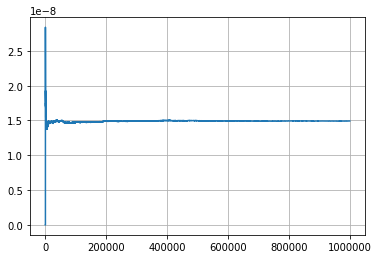

In [214]:
plt.plot(est1[:])
plt.grid()

In [215]:
est1[-1]

1.4928142493643687e-08

In [216]:
fs.right_answer - est1[-1]

3.0183725106894257e-10

In [217]:
alphas[-1]

[array([ 0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.0

In [218]:
x = mixture.sample()

In [219]:
alphas[0]

[array([ 0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.00135135,  0.00135135,
         0.00135135,  0.00135135,  0.00135135,  0.0

In [220]:
proj(alphas[0] - grad(x, alphas[0]))[0, -1] - alphas[0][0][-1] 

0.0

In [221]:
proj(alphas[0] - grad(x, alphas[0]))[0, 1] - alphas[0][0][1] 

0.0

In [222]:
grad(x, alphas[0])

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.])

In [223]:
alphas[-1][0] - alphas[0][0]

array([  2.01952929e-12,   1.00560836e-12,   0.00000000e+00,
         2.65698856e-12,   5.51514715e-12,   7.32187553e-12,
         1.24738329e-11,   1.59668364e-11,   1.93230731e-11,
         2.93617884e-11,   3.32036111e-11,   3.04064243e-11,
         2.85568184e-11,   2.34365695e-11,   2.49359379e-11,
         3.99036750e-11,   5.57027712e-11,   3.33753192e-11,
         3.97936757e-11,   3.40413500e-11,   2.79099981e-11,
         3.46082848e-11,   5.22332973e-11,   5.74954865e-11,
         7.88439338e-11,   5.35570204e-11,   2.83844285e-11,
         2.54327791e-11,   2.76791459e-11,   3.34849295e-11,
         7.29867636e-11,   1.07851774e-10,   7.84436459e-11,
         5.62776347e-11,   6.13536361e-11,   5.14413995e-11,
         5.11841223e-11,   6.15112210e-11,   5.58804244e-11,
         6.07665296e-11,   6.14186566e-11,   4.46348785e-11,
         5.29359865e-11,   5.27073194e-11,   3.93191675e-11,
         4.65495676e-11,   7.05641277e-11,   2.30991144e-10,
         9.05466867e-11,

In [224]:
probas

array([  9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,   9.86587645e-10,   9.86587645e-10,
         9.86587645e-10,

### Second optimization task

#### Owen's realization

In [35]:
simul_num1 = 10**4
simul_num2 = 10**5
dim_alpha = NUM_B + 1
dim_beta = NUM_B
dim_gamma = NUM_B

In [36]:
eta = 1e-2
delta = (1 + eta - (NUM_B + 1)*eps) / (NUM_B + 2)
zero_alpha = (eps + delta) * np.ones((NUM_B + 1)) # zero alpha for optimization
sample_alpha = np.ones((NUM_B + 1)) / (NUM_B + 1) #alpha which will be used for the first simulation stage
sample_alpha[np.argmax(sample_alpha)] += 1 - sample_alpha.sum()
mixture.set_alpha(sample_alpha)
coefs = calculate_coefs(mixture)

In [37]:
def update1(x, direction, t):
    sizes = tuple(len(x_i) for x_i in x)
    start_idx = []
    idx = 0
    for i in range(len(x)):
        start_idx.append(idx)
        idx += sizes[i]
    return [x[i] + t*direction[start_idx[i]: start_idx[i] + sizes[i]] for i in range(len(x))]

In [38]:
#eta = 1e-3
tol_e = 1e-4
rho = 1
zero_beta = np.zeros((NUM_B))
zero_gamma = np.zeros((NUM_B))
dom_func = lambda x: np.all(x[0] >= eps) & (x[0].sum() < 1 + eta)
params_to_opt = (zero_alpha, zero_beta, zero_gamma)
while True:
    print('rho:', rho)
    func_wrap = lambda x: big_func(coefs, x[0], x[1], x[2], rho = rho)
    grad_wrap = lambda x: big_grad(coefs, x[0], x[1], x[2], rho = rho)
    hess_wrap = lambda x: big_hess(coefs, x[0], x[1], x[2], rho = rho)
    params_to_opt = damped_newton(func_wrap, grad_wrap, hess_wrap, dom_func, params_to_opt, update1)
    if (NUM_B + 2) * rho < func(coefs, params_to_opt[0], params_to_opt[1], params_to_opt[2]) * tol_e:
        break
    else: rho = rho / 2

rho: 1
rho: 0.5
rho: 0.25
rho: 0.125
rho: 0.0625
rho: 0.03125
rho: 0.015625
rho: 0.0078125
rho: 0.00390625
rho: 0.001953125
rho: 0.0009765625
rho: 0.00048828125
rho: 0.000244140625
rho: 0.0001220703125
rho: 6.103515625e-05
rho: 3.0517578125e-05
rho: 1.52587890625e-05
rho: 7.62939453125e-06
rho: 3.814697265625e-06
rho: 1.9073486328125e-06
rho: 9.5367431640625e-07
rho: 4.76837158203125e-07
rho: 2.384185791015625e-07
rho: 1.1920928955078125e-07
rho: 5.960464477539063e-08
rho: 2.9802322387695312e-08
rho: 1.4901161193847656e-08
rho: 7.450580596923828e-09
rho: 3.725290298461914e-09
rho: 1.862645149230957e-09
rho: 9.313225746154785e-10
rho: 4.656612873077393e-10
rho: 2.3283064365386963e-10
rho: 1.1641532182693481e-10
rho: 5.820766091346741e-11
rho: 2.9103830456733704e-11
rho: 1.4551915228366852e-11
rho: 7.275957614183426e-12
rho: 3.637978807091713e-12
rho: 1.8189894035458565e-12
rho: 9.094947017729282e-13
rho: 4.547473508864641e-13
rho: 2.2737367544323206e-13
rho: 1.1368683772161603e-13
rho: 

In [39]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params_to_opt[0], params_to_opt[1], params_to_opt[2])

1.5230897611485257e-08

In [40]:
fs.right_answer - get_estimation(mixture, proj, params_to_opt[0], params_to_opt[1], params_to_opt[2])

-4.6279676196604716e-12

#### Sgd for second optimization task

In [41]:
obj = lambda x, params: obj1(x, mixture, params[0], params[1], params[2])
grad = lambda x, params: grad1(x, mixture, params[0], params[1], params[2])


In [42]:
zero_a = (1 / (NUM_B + 1)) * np.ones((NUM_B + 1))
zero_b = np.zeros((NUM_B))
zero_g = np.zeros((NUM_B))
zero_p = (zero_a, zero_b, zero_g)
proj = SimplexProjector(epsilon = eps)

In [43]:
est2, params2 = sgd(obj, mixture, grad, zero_p, proj, max_iter= 10**5, momentum=0.9)

Iteration #1000
Iteration #2000
Iteration #3000
Iteration #4000
Iteration #5000
Iteration #6000
Iteration #7000
Iteration #8000
Iteration #9000
Iteration #10000
Iteration #11000
Iteration #12000
Iteration #13000
Iteration #14000
Iteration #15000
Iteration #16000
Iteration #17000
Iteration #18000
Iteration #19000
Iteration #20000
Iteration #21000
Iteration #22000
Iteration #23000
Iteration #24000
Iteration #25000
Iteration #26000
Iteration #27000
Iteration #28000
Iteration #29000
Iteration #30000
Iteration #31000
Iteration #32000
Iteration #33000
Iteration #34000
Iteration #35000
Iteration #36000
Iteration #37000
Iteration #38000
Iteration #39000
Iteration #40000
Iteration #41000
Iteration #42000
Iteration #43000
Iteration #44000
Iteration #45000
Iteration #46000
Iteration #47000
Iteration #48000
Iteration #49000
Iteration #50000
Iteration #51000
Iteration #52000
Iteration #53000
Iteration #54000
Iteration #55000
Iteration #56000
Iteration #57000
Iteration #58000
Iteration #59000
Iterat

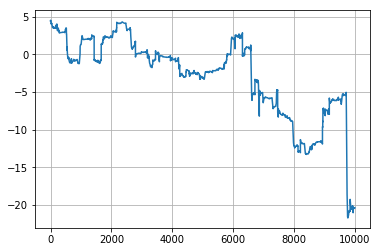

In [44]:
plt.plot(est2[-10000:])
plt.grid()

In [48]:
est2[-1]

-20.391041294700408

In [49]:
coefs = calculate_coefs(mixture)

In [51]:
func(coefs, params2[-1][0], params2[-1][1], params2[-1][2], sample_num=1)

40209773025.356339

In [52]:
func(coefs, params2[0][0], sample_num=1)

3.0442441805449034e-12

In [57]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params2[-1][0], params2[-1][1], params2[-1][2])

-1.6854558991228856

## Second simulation

In [58]:
ss = read_matpower.second_simulation()
W, tau = ss()

In [59]:
probas = calculate_probas(W, tau)

In [60]:
# elimination of values that are too rare (so that further computations become possible)
critical_value = 1e-300
valid_idx = np.argwhere(probas >= critical_value)[:,0]
probas = probas[valid_idx]
W = W[valid_idx]
tau = tau[valid_idx]

In [61]:
DIM_X = W.shape[1]
NUM_B = W.shape[0]
eps = 0.1 / (NUM_B + 1) # lower bound which prevents alpha values from being equal to zero



#W = np.random.randn(NUM_B, DIM_X)
#W = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, W)
#tau = np.fabs(np.random.randn(NUM_B))

In [62]:
boundaries_wrap = lambda x: boundaries(x, W, tau)

In [63]:
generate_wrap = lambda i: generate_sample(W, tau, i)

In [64]:
dist_func = lambda x: multivariate_normal.pdf(x, np.zeros((DIM_X)), np.identity(DIM_X))
mixture = Mixture(dist_func, boundaries_wrap, probas, generate_wrap)

### First optimisation task

#### Owen's realisation

In [65]:
simul_num1 = 10**4
simul_num2 = 10**5
dim_alpha = NUM_B + 1
dim_beta = NUM_B
dim_gamma = NUM_B

In [66]:
eta = 1e-2
delta = (1 + eta - (NUM_B + 1)*eps) / (NUM_B + 2)
zero_alpha = (eps + delta) * np.ones((NUM_B + 1)) # zero alpha for optimization
sample_alpha = np.ones((NUM_B + 1)) / (NUM_B + 1) #alpha which will be used for the first simulation stage
sample_alpha[np.argmax(sample_alpha)] += 1 - sample_alpha.sum()
mixture.set_alpha(sample_alpha)
coefs = calculate_coefs(mixture)

In [68]:
#eta = 1e-3
tol_e = 1e-4
rho = 1
dom_func = lambda x: np.all(x >= eps) & (x.sum() < 1 + eta)
params_to_opt = zero_alpha
while True:
    print('rho:', rho)
    func_wrap = lambda x: big_func(coefs, x, rho = rho)
    grad_wrap = lambda x: big_grad(coefs, x, rho = rho)
    hess_wrap = lambda x: big_hess(coefs, x, rho = rho)
    params_to_opt = damped_newton(func_wrap, grad_wrap, hess_wrap, dom_func, params_to_opt, update=update1)
    if (NUM_B + 2) * rho < func(coefs, params_to_opt) * tol_e:
        break
    else: rho = rho / 2

rho: 1
rho: 0.5
rho: 0.25
rho: 0.125
rho: 0.0625
rho: 0.03125
rho: 0.015625
rho: 0.0078125
rho: 0.00390625
rho: 0.001953125
rho: 0.0009765625
rho: 0.00048828125
rho: 0.000244140625
rho: 0.0001220703125
rho: 6.103515625e-05
rho: 3.0517578125e-05
rho: 1.52587890625e-05
rho: 7.62939453125e-06
rho: 3.814697265625e-06
rho: 1.9073486328125e-06
rho: 9.5367431640625e-07
rho: 4.76837158203125e-07
rho: 2.384185791015625e-07
rho: 1.1920928955078125e-07
rho: 5.960464477539063e-08
rho: 2.9802322387695312e-08
rho: 1.4901161193847656e-08
rho: 7.450580596923828e-09
rho: 3.725290298461914e-09
rho: 1.862645149230957e-09
rho: 9.313225746154785e-10
rho: 4.656612873077393e-10
rho: 2.3283064365386963e-10
rho: 1.1641532182693481e-10
rho: 5.820766091346741e-11
rho: 2.9103830456733704e-11
rho: 1.4551915228366852e-11
rho: 7.275957614183426e-12
rho: 3.637978807091713e-12
rho: 1.8189894035458565e-12
rho: 9.094947017729282e-13
rho: 4.547473508864641e-13
rho: 2.2737367544323206e-13
rho: 1.1368683772161603e-13
rho: 

In [69]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params_to_opt)

1.4817029108277771e-08

In [71]:
fs.right_answer

1.5229979744712629e-08

#### Stochastic gradient descent

In [72]:
obj = lambda x, params: obj1(x, mixture, params[0])
grad = lambda x, params: grad1(x, mixture, params[0])


In [73]:
zero_p = (1 / (NUM_B + 1)) * np.ones((NUM_B + 1))
proj = SimplexProjector(epsilon = eps)

In [74]:
zero_p = [zero_p]

In [75]:
est1, alphas = sgd(obj, mixture, grad, zero_p, proj, max_iter= 10**5)

Iteration #1000
Iteration #2000
Iteration #3000
Iteration #4000
Iteration #5000
Iteration #6000
Iteration #7000
Iteration #8000
Iteration #9000
Iteration #10000
Iteration #11000
Iteration #12000
Iteration #13000
Iteration #14000
Iteration #15000
Iteration #16000
Iteration #17000
Iteration #18000
Iteration #19000
Iteration #20000
Iteration #21000
Iteration #22000
Iteration #23000
Iteration #24000
Iteration #25000
Iteration #26000
Iteration #27000
Iteration #28000
Iteration #29000
Iteration #30000
Iteration #31000
Iteration #32000
Iteration #33000
Iteration #34000
Iteration #35000
Iteration #36000
Iteration #37000
Iteration #38000
Iteration #39000
Iteration #40000
Iteration #41000
Iteration #42000
Iteration #43000
Iteration #44000
Iteration #45000
Iteration #46000
Iteration #47000
Iteration #48000
Iteration #49000
Iteration #50000
Iteration #51000
Iteration #52000
Iteration #53000
Iteration #54000
Iteration #55000
Iteration #56000
Iteration #57000
Iteration #58000
Iteration #59000
Iterat

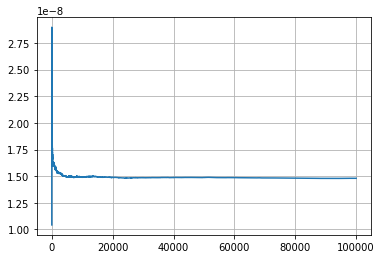

In [76]:
plt.plot(est1[:])
plt.grid()

In [77]:
est1[-1]

1.4802068409268742e-08

In [78]:
fs.right_answer - est1[-1]

4.2791133544388732e-10

### Second optimization task

#### Owen's realization

In [79]:
simul_num1 = 10**4
simul_num2 = 10**5
dim_alpha = NUM_B + 1
dim_beta = NUM_B
dim_gamma = NUM_B

In [80]:
eta = 1e-2
delta = (1 + eta - (NUM_B + 1)*eps) / (NUM_B + 2)
zero_alpha = (eps + delta) * np.ones((NUM_B + 1)) # zero alpha for optimization
sample_alpha = np.ones((NUM_B + 1)) / (NUM_B + 1) #alpha which will be used for the first simulation stage
sample_alpha[np.argmax(sample_alpha)] += 1 - sample_alpha.sum()
mixture.set_alpha(sample_alpha)
coefs = calculate_coefs(mixture)

In [81]:
def update1(x, direction, t):
    sizes = tuple(len(x_i) for x_i in x)
    start_idx = []
    idx = 0
    for i in range(len(x)):
        start_idx.append(idx)
        idx += sizes[i]
    return [x[i] + t*direction[start_idx[i]: start_idx[i] + sizes[i]] for i in range(len(x))]

In [82]:
#eta = 1e-3
tol_e = 1e-4
rho = 1
zero_beta = np.zeros((NUM_B))
zero_gamma = np.zeros((NUM_B))
dom_func = lambda x: np.all(x[0] >= eps) & (x[0].sum() < 1 + eta)
params_to_opt = (zero_alpha, zero_beta, zero_gamma)
while True:
    print('rho:', rho)
    func_wrap = lambda x: big_func(coefs, x[0], x[1], x[2], rho = rho)
    grad_wrap = lambda x: big_grad(coefs, x[0], x[1], x[2], rho = rho)
    hess_wrap = lambda x: big_hess(coefs, x[0], x[1], x[2], rho = rho)
    params_to_opt = damped_newton(func_wrap, grad_wrap, hess_wrap, dom_func, params_to_opt, update1)
    if (NUM_B + 2) * rho < func(coefs, params_to_opt[0], params_to_opt[1], params_to_opt[2]) * tol_e:
        break
    else: rho = rho / 2

rho: 1
rho: 0.5
rho: 0.25
rho: 0.125
rho: 0.0625
rho: 0.03125
rho: 0.015625
rho: 0.0078125
rho: 0.00390625
rho: 0.001953125
rho: 0.0009765625
rho: 0.00048828125
rho: 0.000244140625
rho: 0.0001220703125
rho: 6.103515625e-05
rho: 3.0517578125e-05
rho: 1.52587890625e-05
rho: 7.62939453125e-06
rho: 3.814697265625e-06
rho: 1.9073486328125e-06
rho: 9.5367431640625e-07
rho: 4.76837158203125e-07
rho: 2.384185791015625e-07
rho: 1.1920928955078125e-07
rho: 5.960464477539063e-08
rho: 2.9802322387695312e-08
rho: 1.4901161193847656e-08
rho: 7.450580596923828e-09
rho: 3.725290298461914e-09
rho: 1.862645149230957e-09
rho: 9.313225746154785e-10
rho: 4.656612873077393e-10
rho: 2.3283064365386963e-10
rho: 1.1641532182693481e-10
rho: 5.820766091346741e-11
rho: 2.9103830456733704e-11
rho: 1.4551915228366852e-11
rho: 7.275957614183426e-12
rho: 3.637978807091713e-12
rho: 1.8189894035458565e-12
rho: 9.094947017729282e-13
rho: 4.547473508864641e-13
rho: 2.2737367544323206e-13
rho: 1.1368683772161603e-13
rho: 

In [83]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params_to_opt[0], params_to_opt[1], params_to_opt[2])

1.4823021910417334e-08

In [84]:
fs.right_answer - get_estimation(mixture, proj, params_to_opt[0], params_to_opt[1], params_to_opt[2])

4.2816745327303973e-10

#### Sgd for second optimization task

In [134]:
obj = lambda x, params: obj1(x, mixture, params[0], params[1], params[2])
grad = lambda x, params: grad1(x, mixture, params[0], params[1], params[2])


In [135]:
zero_a = (1 / (NUM_B + 1)) * np.ones((NUM_B + 1))
zero_b = np.zeros((NUM_B))
zero_g = np.zeros((NUM_B))
zero_p = (zero_a, zero_b, zero_g)
proj = SimplexProjector(epsilon = eps)

In [144]:
est2, params2 = sgd(obj, mixture, grad, zero_p, proj, max_iter= 10**6, momentum=0.9, C= 1)

Iteration #1000
Iteration #2000
Iteration #3000
Iteration #4000
Iteration #5000
Iteration #6000
Iteration #7000
Iteration #8000
Iteration #9000
Iteration #10000
Iteration #11000
Iteration #12000
Iteration #13000
Iteration #14000
Iteration #15000
Iteration #16000
Iteration #17000
Iteration #18000
Iteration #19000
Iteration #20000
Iteration #21000
Iteration #22000
Iteration #23000
Iteration #24000
Iteration #25000
Iteration #26000
Iteration #27000
Iteration #28000
Iteration #29000
Iteration #30000
Iteration #31000
Iteration #32000
Iteration #33000
Iteration #34000
Iteration #35000
Iteration #36000
Iteration #37000
Iteration #38000
Iteration #39000
Iteration #40000
Iteration #41000
Iteration #42000
Iteration #43000
Iteration #44000
Iteration #45000
Iteration #46000
Iteration #47000
Iteration #48000
Iteration #49000
Iteration #50000
Iteration #51000
Iteration #52000
Iteration #53000
Iteration #54000
Iteration #55000
Iteration #56000
Iteration #57000
Iteration #58000
Iteration #59000
Iterat

Iteration #463000
Iteration #464000
Iteration #465000
Iteration #466000
Iteration #467000
Iteration #468000
Iteration #469000
Iteration #470000
Iteration #471000
Iteration #472000
Iteration #473000
Iteration #474000
Iteration #475000
Iteration #476000
Iteration #477000
Iteration #478000
Iteration #479000
Iteration #480000
Iteration #481000
Iteration #482000
Iteration #483000
Iteration #484000
Iteration #485000
Iteration #486000
Iteration #487000
Iteration #488000
Iteration #489000
Iteration #490000
Iteration #491000
Iteration #492000
Iteration #493000
Iteration #494000
Iteration #495000
Iteration #496000
Iteration #497000
Iteration #498000
Iteration #499000
Iteration #500000
Iteration #501000
Iteration #502000
Iteration #503000
Iteration #504000
Iteration #505000
Iteration #506000
Iteration #507000
Iteration #508000
Iteration #509000
Iteration #510000
Iteration #511000
Iteration #512000
Iteration #513000
Iteration #514000
Iteration #515000
Iteration #516000
Iteration #517000
Iteration 

Iteration #919000
Iteration #920000
Iteration #921000
Iteration #922000
Iteration #923000
Iteration #924000
Iteration #925000
Iteration #926000
Iteration #927000
Iteration #928000
Iteration #929000
Iteration #930000
Iteration #931000
Iteration #932000
Iteration #933000
Iteration #934000
Iteration #935000
Iteration #936000
Iteration #937000
Iteration #938000
Iteration #939000
Iteration #940000
Iteration #941000
Iteration #942000
Iteration #943000
Iteration #944000
Iteration #945000
Iteration #946000
Iteration #947000
Iteration #948000
Iteration #949000
Iteration #950000
Iteration #951000
Iteration #952000
Iteration #953000
Iteration #954000
Iteration #955000
Iteration #956000
Iteration #957000
Iteration #958000
Iteration #959000
Iteration #960000
Iteration #961000
Iteration #962000
Iteration #963000
Iteration #964000
Iteration #965000
Iteration #966000
Iteration #967000
Iteration #968000
Iteration #969000
Iteration #970000
Iteration #971000
Iteration #972000
Iteration #973000
Iteration 

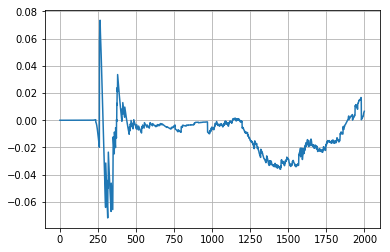

In [161]:
plt.plot(est2[:2000])
plt.grid()

In [146]:
est2[-1]

-9.0107209423096525e+17

In [150]:
params2[2]

[array([ 0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.01351351,  0.01351351,
         0.01351351,  0.01351351,  0.01351351,  0.0

In [141]:
coefs = calculate_coefs(mixture)

In [142]:
func(coefs, params2[-1][0], params2[-1][1], params2[-1][2], sample_num=1)

2.4160943810411947e+33

In [143]:
func(coefs, params2[0][0], sample_num=1)

3.3433141490993673e-12

In [124]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params2[-1][0], params2[-1][1], params2[-1][2], sample_num = 10**6)

1.5960142994704256

In [119]:
proj = SimplexProjector(eps)
get_estimation(mixture, proj, params2[-1][0], sample_num=10**5)

1.4979160964281355e-08